In [1]:
import pypsa
import pandas as pd
import numpy as np

In [2]:
solver = "cbc"

*** 
Check-point 1:

**Build a network in PyPSA with one nodes (`bus`) and following components to build a simple green electricity production system:**

1. An `Electricity` bus with electricity as `carrier`.
   1. A wind generator inside this bus.
   2. A hydro generator inside this bus.
   3. An electricity demand load inside this bus.

**We will supply electricy by attaching one wind power plant implemented as (`generator`) (you have to call [`network.set_snapshots`](https://pypsa-readthedocs.readthedocs.io/en/readthedocs/api_reference.html?highlight=set_snapshots) to select a year). As help you should have a look at the [PyPSA documentation](https://pypsa-readthedocs.readthedocs.io/en/readthedocs/index.html) and the [minimal lopf example](https://www.pypsa.org/examples/minimal_example_lopf.html), understand what the [components documentation](https://pypsa-readthedocs.readthedocs.io/en/readthedocs/components.html) of PyPSA gives you and that you can find the underlying objective function and constraints in the [LOPF documentation](https://pypsa-readthedocs.readthedocs.io/en/readthedocs/optimal_power_flow.html).**


> **Remarks:** For time reasons, you do not have to build the network from scratch. However, to get you acquainted with PyPSA we have omitted a few elements or some of the parameters of the network marked by three question marks `???`. Either, you have to add an element similar to the one in the box above or add a few parameters.

#### Initialize network

In [3]:
# Create empty PyPSA network
network = pypsa.Network()

In [4]:
# Set snapshots to the year 2023 and at hourly resolution
snapshots = pd.date_range("01-01-2023", "01-01-2024", freq="H", inclusive="left")
network.set_snapshots(snapshots)

In [5]:
network.snapshots

DatetimeIndex(['2023-01-01 00:00:00', '2023-01-01 01:00:00',
               '2023-01-01 02:00:00', '2023-01-01 03:00:00',
               '2023-01-01 04:00:00', '2023-01-01 05:00:00',
               '2023-01-01 06:00:00', '2023-01-01 07:00:00',
               '2023-01-01 08:00:00', '2023-01-01 09:00:00',
               ...
               '2023-12-31 14:00:00', '2023-12-31 15:00:00',
               '2023-12-31 16:00:00', '2023-12-31 17:00:00',
               '2023-12-31 18:00:00', '2023-12-31 19:00:00',
               '2023-12-31 20:00:00', '2023-12-31 21:00:00',
               '2023-12-31 22:00:00', '2023-12-31 23:00:00'],
              dtype='datetime64[ns]', name='snapshot', length=8760, freq='H')

In [6]:
# Import an example of wind daily pattern
wind_pattern = pd.read_csv("../data/weather data/example_onshore_wind_daily_pattern.csv")["daily pattern"]
# annual time-series availability of onshore wind (just a simplified example)
wind_profile = pd.Series(list(wind_pattern)*365, index=network.snapshots)

<Axes: xlabel='snapshot'>

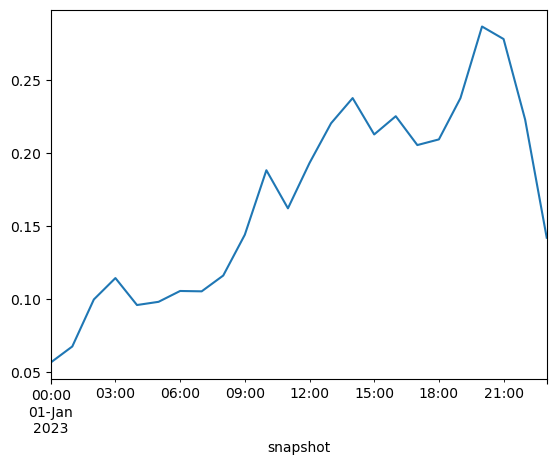

In [7]:
wind_profile.head(24).plot()

Add an `electricity` bus with electricity as `carrier`

In [8]:
network.add(class_name="Bus", name="electricity", carrier="electricity")

In [ ]:
network.buses

attribute,v_nom,type,x,y,carrier,unit,v_mag_pu_set,v_mag_pu_min,v_mag_pu_max,control,sub_network
Bus,,,,,,,,,,,
electricity,1.0,,0.0,0.0,electricity,None,1.0,0.0,inf,PQ,


Add constant hourly load of `100MW` at the electricity bus. The name of the load can be `electricity_load`

In [10]:
network.add(class_name="Load", name="electricity_load", bus="electricity", p_set=100)

In [11]:
network.loads

attribute,bus,carrier,type,p_set,q_set,sign
Load,,,,,,
electricity_load,electricity,,,100.0,0.0,-1.0


Add a wind generator at the electricity bus with a initial capacity of `100MW`, maximum capacity of `500MW`, and marginal cost of `0$/MWh` into the network? The name of the generator can be `onshore_wind`. 

In [12]:
network.add(
      class_name="Generator", 
      name="onshore_wind",
      bus="electricity",
      carrier="electricity",
      p_nom_extendable=True,
      p_nom=100, # MW
      p_nom_max=500, # MW
      marginal_cost=0, #$/MWh
      p_max_pu=wind_profile
)

Add a hydro generator at the electricity bus with a constant capacity of `200MW`, and marginal cost of `0$/MWh` into the network? The name of the generator can be `hydro_dam`. 

In [13]:
network.add(
      class_name="Generator", 
      name="hydro_dam",
      bus="electricity",
      carrier="electricity",
      p_nom_extendable=False,
      p_nom=200, # MW
      marginal_cost=0, #$/MWh
)

Now try to solve your network

In [14]:
# Solve network using cbc solver
network.optimize(pyomo=False, solver_name="cbc")

/home/darlene/mambaforge/envs/pypsa-agora-lcoh/lib/python3.10/site-packages/numpy/core/numeric.py:407: RuntimeWarning:

invalid value encountered in cast

INFO:linopy.model: Solve linear problem using Cbc solver
INFO:linopy.model:Solver options:
 - pyomo: False
INFO:linopy.io:Writing objective.
Writing variables.: 100%|██████████| 2/2 [00:00<00:00, 92.87it/s]
INFO:linopy.io: Writing time: 0.19s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 17521 primals, 43802 duals
Objective: 0.00e+00
Solver model: not available
Solver message: Optimal - objective value 0.00000000




Welcome to the CBC MILP Solver 
Version: 2.10.10 
Build Date: Apr 19 2023 

command line - cbc -printingOptions all -import /tmp/linopy-problem-6nvysg22.lp -pyomo False -solve -solu /tmp/linopy-solve-h84wt23l.sol (default strategy 1)
Option for printingOptions changed from normal to all
No match for pyomo - ? for list of commands
No match for False - ? for list of commands
Presolve 0 (-43802) rows, 0 (-17521) columns and 0 (-61322) elements
Empty problem - 0 rows, 0 columns and 0 elements
Optimal - objective value 0
After Postsolve, objective 0, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective 0 - 0 iterations time 0.022, Presolve 0.02
Total time (CPU seconds):       0.34   (Wallclock seconds):       0.19



('ok', 'optimal')

Lets look at some results! Back to read the docs. How would you look at results?

<Axes: xlabel='snapshot'>

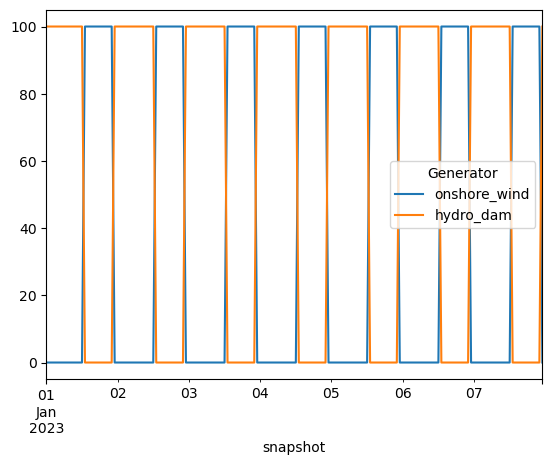

In [19]:
network.generators_t.p[:24*7].plot()

In [17]:
network.loads_t.p.head()

Load,electricity_load
snapshot,
2023-01-01 00:00:00,100.0
2023-01-01 01:00:00,100.0
2023-01-01 02:00:00,100.0
2023-01-01 03:00:00,100.0
2023-01-01 04:00:00,100.0


Ending of check-point 1 - export network

In [20]:
# Export network
network.export_to_netcdf("../results/network_d2_e1-1.nc")

INFO:pypsa.io:Exported network network_d2_e1-1.nc has generators, buses, loads


<xarray.Dataset> Size: 631kB
Dimensions:                       (snapshots: 8760, investment_periods: 0,
                                   generators_i: 2, generators_t_p_max_pu_i: 1,
                                   generators_t_p_i: 2, buses_i: 1, loads_i: 1,
                                   loads_t_p_i: 1)
Coordinates:
  * snapshots                     (snapshots) int64 70kB 0 1 2 ... 8758 8759
  * investment_periods            (investment_periods) int64 0B 
  * generators_i                  (generators_i) object 16B 'onshore_wind' 'h...
  * generators_t_p_max_pu_i       (generators_t_p_max_pu_i) object 8B 'onshor...
  * generators_t_p_i              (generators_t_p_i) object 16B 'onshore_wind...
  * buses_i                       (buses_i) object 8B 'electricity'
  * loads_i                       (loads_i) object 8B 'electricity_load'
  * loads_t_p_i                   (loads_t_p_i) object 8B 'electricity_load'
Data variables: (12/18)
    snapshots_snapshot            (snapshots) datetime64[ns] 70kB 2023-01-01 ...
    snapshots_objective           (snapshots) float64 70kB 1.0 1.0 ... 1.0 1.0
    snapshots_stores              (snapshots) float64 70kB 1.0 1.0 ... 1.0 1.0
    snapshots_generators          (snapshots) float64 70kB 1.0 1.0 ... 1.0 1.0
    investment_periods_objective  (investment_periods) object 0B 
    investment_periods_years      (investment_periods) object 0B 
    ...                            ...
    generators_t_p_max_pu         (snapshots, generators_t_p_max_pu_i) float64 70kB ...
    generators_t_p                (snapshots, generators_t_p_i) float64 140kB ...
    buses_carrier                 (buses_i) object 8B 'electricity'
    loads_bus                     (loads_i) object 8B 'electricity'
    loads_p_set                   (loads_i) float64 8B 100.0
    loads_t_p                     (snapshots, loads_t_p_i) float64 70kB 100.0...
Attributes:
    network__linearized_uc:      0
    network__multi_invest:       0
    network_name:                
    network_objective:           0.0
    network_objective_constant:  0.0
    network_pypsa_version:       0.28.0
    network_srid:                4326
    crs:                         {"_crs": "GEOGCRS[\"WGS 84\",ENSEMBLE[\"Worl...
    meta:                        {}